# Statistical Analysis
#### Project Overview
The goal of this project is to create a model that predicts whether or not a drug review will have a good rating, based on the review text.

#### Data Overview
| Column Name     | Column Description                          | 
| :---            | :---                                        |
| reviewID        | Unique review ID                            |
| drugName        | Name of drug being reviewed                 |
| condition       | Condition drug was used for                 |
| review          | Review text                                 |
| rating          | Rating from 1 to 10                         |
| date            | Date of review                              |
| usefulCount     | Number of times the review was voted useful |
| char_count      | Number of characters in the original review |
| clean_review    | Cleaned and preprocessed review text        |

#### Statistical Analysis Goals
My goals for this step are to: 
1. Explore data distributions and statistics
2. Discover statisticlaly significant relationships
2. Understand top features for machine learning

## Import
I imported libraries that will be used along with data from previous steps.

In [75]:
# import libraries
import numpy as np
import pandas as pd

# statistics
from scipy import stats

# visualization libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('notebook')
sns.set_palette('muted')

# data import/export
from scipy.sparse import load_npz
import pickle

In [76]:
# import datarame
reviews_df = pd.read_pickle('drugreviews_df')

# import sparse term matrix
term_matrix = load_npz('ngram_csr.npz')

# convert sparse matrix to dataframe
term_matrix = pd.DataFrame(term_matrix.todense())

# import column headers for dataframe
pickle_in = open('list.pickle', 'rb')
reviews_columns = pickle.load(pickle_in)

# add column headers back to dataframe
term_matrix.columns = reviews_columns

## 1. Rating by Review Length

### 1a. Visualization
I used box plots to see if there a relationship between review length and rating could be seen. I chose to use both character count and word count calculated prior to cleaning and preprocessing the text.

In [77]:
reviews_df.head()

,reviewID,drugName,condition,review,rating,date,usefulCount,char_count,clean_review
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,2012-05-20,27,79,side effect take combin bystol mg fish oil
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,2010-04-27,192,741,son halfway fourth week intuniv becam concern ...
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,2009-12-14,17,755,use take anoth oral contracept pill cycl happi...
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,2015-11-03,10,448,first time use form birth control glad went pa...
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,2016-11-27,37,719,suboxon complet turn life around feel healthie...


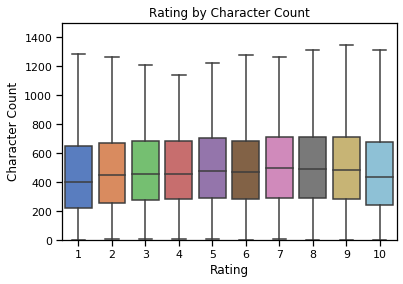

In [78]:
# boxplot of character count vs. rating
sns.boxplot(x='rating', y='char_count', data=reviews_df, sym='')
plt.title('Rating by Character Count')
plt.xlabel('Rating')
plt.ylabel('Character Count')
plt.ylim(0,1500)
plt.show()

### 1b. Significant Correlation
There wasn't a clear relationship between review length and rating in the boxplots, so I wanted to take a more quantitative approach.

My null hypothesis was that there was not a correlation (i.e. correlation coefficient was zero). My alternative hypothesis was that there was a correlation (i.e. correlation coefficient was not zero).

An alpha (p-value) of 0.05 was used to determine statistical significance.

#### Character Count
Character count also had a statistically significant correlation, but a very weak one. The correlation coefficient between character count and rating was about 0.021.

In [79]:
# calculate perason correlation coefficient and p-value
corr_coeff, p = stats.pearsonr(reviews_df['rating'], reviews_df['char_count'])

# print correlation coefficient
print(f'Correlation coefficent: {corr_coeff:.4f}')
print(f'P-value: {p:.4}')

Correlation coefficent: 0.0206
P-value: 1.139e-16


## 2. Rating by Drug Name

To minimize outliers or drugs with a small sample size, I filtered out drugs that appeared less than 50 times.

In [80]:
# only include drugs that have at least 50 reviews
drug_names = reviews_df['drugName'].unique()
drug_counts = np.array([(i, reviews_df[reviews_df['drugName'] == i]['drugName'].count()) for i in drug_names])
drug_names_50 = [i[0] for i in drug_counts if i[1] >= '50']

### 2a. T-Test for Statistically Significant Avg. Difference
I used a t-test to determine which drugs had a statistically significant effect on average rating.

My null hypothesis was that there was no difference between the average rating with and without the chosen drug. My alternative hypothesis was that there was a difference between rating with and without the chosen drug.

I used an alpha (p-value) of 0.5 and ran the t-test on each drug that appeared at least 50 times in the data.

In [81]:
# set alpha for t-test
alpha = 0.05

# define function for t-test
def ttest(data, column, value):
    '''Function to run a t-test and return a value with its p-value.'''
    has = data[data[column] == value].rating
    has_not = data[data[column] != value].rating
    t, p = stats.ttest_ind(has, has_not)
    return p

In [82]:
# perform t-test on ratings with and without each drug
pvalue_drugs = [(i, ttest(data, 'drugName', i)) for i in drug_names_50]

# return drugs with p-values below alpha and their p-values as an array
sig_drugs = [(i[0], float(i[1])) for i in pvalue_drugs if float(i[1]) < alpha]

# sort by p-value
sig_drugs.sort(key=lambda x:x[1])

### 2b. Significant Average Difference in Rating
After determining drugs with a significant average difference in rating, I looked at which drugs had the largest average difference.

In [83]:
def diff_avg(data, column, value):
    """Return difference of mean ratings with and without each drug."""
    has = np.mean(data[data[column] == value].rating)
    has_not = np.mean(data[data[column] != value].rating)
    diff = has - has_not
    return diff

In [100]:
# make a list of sig_drugs
sig_drugs_list = [i[0] for i in sig_drugs]

# avgerage difference of mean rating for each drug
diff_avg_drugs = [(i, diff_avg(data, 'drugName', i)) for i in sig_drugs_list]

# sort by average difference
diff_avg_drugs.sort(key=lambda x:x[1])

# print number of drugs with significant avg. differences
print(f'Number of drugs with significant average differences in rating: {len(diff_avg_drugs)}')

Number of drugs with significant average differences in rating: 237


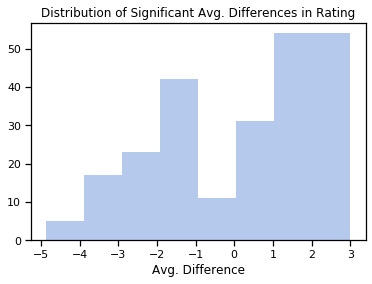

,diff_avg
count,237.000000
mean,0.159351
std,2.052787
min,-4.872392
25%,-1.410355
50%,0.883821
75%,1.860731
max,3.003022


In [85]:
# create dataframe of significant average rating differences by drug
diff_avg_drugs = pd.DataFrame(diff_avg_drugs, columns=['drug_name', 'diff_avg'])

# plot distribution of significange average differences
sns.distplot(diff_avg_drugs['diff_avg'], kde=False)
plt.xlabel('Avg. Difference')
plt.title('Distribution of Significant Avg. Differences in Rating')
plt.show()

# print summary statistics of significant average differences by drug
display(diff_avg_drugs.describe())

In [86]:
# print 10 drugs with the largest sig. average increase in rating
top_drugs_sig_diffs = diff_avg_drugs.sort_values('diff_avg', ascending=False)[:10]
display('Top 10 sig. average increase in rating by drug: ', top_drugs_sig_diffs)

# print 10 drugs with largest average decrease
bottom_drugs_sig_diffs = diff_avg_drugs.sort_values('diff_avg', ascending=True)[:10]
display('10 drugs with largest average decrease in rating:', bottom_drugs_sig_diffs)

'Top 10 sig. average increase in rating by drug: '

,drug_name,diff_avg
236,Privine,3.003022
235,Zinc oxide,3.003003
234,Astelin,3.003003
233,Chlorpheniramine / phenylephrine,3.002966
232,Acetaminophen / pseudoephedrine,3.002966
231,Biafine,2.860121
230,Niravam,2.860121
229,Avonex Pen,2.836293
228,Primatene Mist,2.836293
227,Belladonna / opium,2.836293


'10 drugs with largest average decrease in rating:'

,drug_name,diff_avg
0,Systane,-4.872392
1,Succinylcholine,-4.622379
2,Trimethoprim,-4.247360
3,Chloraseptic Sore Throat Spray,-3.997323
4,Monistat 7,-3.966431
5,Blisovi 24 Fe,-3.886957
6,Rhofade,-3.775138
7,"Influenza virus vaccine, live, trivalent",-3.664021
8,Blisovi Fe 1 / 20,-3.528844
9,Delsym,-3.511409


## 3. Rating by Condition

To help minimize outliers and conditions with a small sample size I filtered out conditions that appeared less than 50 times in the data.

In [87]:
# only include conditions that have at least 50 reviews
condition_names = reviews_df['condition'].unique()
condition_counts = np.array([(i, reviews_df[reviews_df['condition'] == i]['condition'].count()) for i in condition_names])
condition_names_50 = [i[0] for i in condition_counts if i[1] >= '50']

### 3a. T-Test for Statistically Significant Avg. Difference
Again, t-test was used to determine which conditions had a statistically significant effect on average difference of rating.

My null hypothesis was that there was no difference between the average rating with and without the chosen condition. My alternative hypothesis was that there was a difference between rating with and without the chosen condition.

I used an alpha (p-value) of 0.5 and ran the t-test on each condition that appeared at least 50 times in the data.

In [88]:
# set alpha for t-test
alpha = 0.05

In [89]:
# perform t-test on ratings with and without each drug
pvalue_conditions = [(i, ttest(reviews_df, 'condition', i)) for i in condition_names_50]

# only include drugs with p-values below alpha
sig_conditions = [(i[0], i[1]) for i in pvalue_conditions if float(i[1]) < alpha]

# sort
sig_conditions.sort(key=lambda x: x[1])

### 3b. Significant Average Difference in Rating
Out of the conditions with a statistically significant average difference in rating, I determined which conditions had the largest average difference.

In [90]:
# make a list of sig_drugs
sig_conditions_list = [i[0] for i in sig_conditions]

# avgerage difference of mean rating for each drug
diff_avg_conditions = [(i, diff_avg(reviews_df, 'condition', i)) for i in sig_conditions_list]

# sort by average difference
diff_avg_conditions.sort(key=lambda x:x[1])

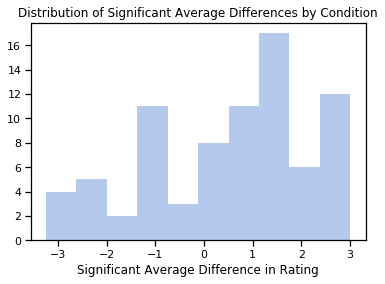

,diff_avg
count,79.000000
mean,0.532271
std,1.691831
min,-3.244538
25%,-0.816970
50%,0.810433
75%,1.692762
max,3.005791


In [91]:
# create dataframe of sig. average differences in rating by condition
diff_avg_conditions = pd.DataFrame(diff_avg_conditions, columns=['condition', 'diff_avg'])

# plot distribution of average difference
sns.distplot(diff_avg_conditions['diff_avg'], bins=10, kde=False)
plt.xlabel('Significant Average Difference in Rating')
plt.title('Distribution of Significant Average Differences by Condition')
plt.show()

# print summary statistics of sig. average differences in rating by condition
display(diff_avg_conditions.describe())

In [92]:
# display 10 conditions with largest average increase
top_diff_avg_conditions = diff_avg_conditions.sort_values('diff_avg', ascending=False)[:10]
display('10 conditions with largest average increase in rating:', top_diff_avg_conditions)

# display 10 conditions with largest average decrease
bottom_diff_avg_conditions = diff_avg_conditions.sort_values('diff_avg', ascending=True)[:10]
display('10 conditions with largest average decrease in rating:', bottom_diff_avg_conditions)

'10 conditions with largest average increase in rating:'

,condition,diff_avg
78,Menopausal Disorders,3.005791
77,Costochondritis,3.005791
76,B12 Nutritional Deficiency,3.005772
75,von Willebrand's Disease,3.005754
74,Gingivitis,3.005735
73,NSAID-Induced Gastric Ulce,2.862890
72,Dumping Syndrome,2.839062
69,Biliary Cirrhosis,2.672389
68,Mucositis,2.672389
70,amilial Mediterranean Feve,2.672389


'10 conditions with largest average decrease in rating:'

,condition,diff_avg
0,Bronchospasm Prophylaxis,-3.244538
1,Sore Throat,-3.105661
2,"Herpes Zoster, Prophylaxis",-2.994488
3,Macular Edema,-2.851643
4,Pancreatic Exocrine Dysfunction,-2.494501
5,"Deep Vein Thrombosis, Recurrent Event",-2.438957
6,Prostatitis,-2.435311
7,Body Dysmorphic Disorde,-2.216723
8,Pelvic Inflammatory Disease,-2.216723
9,Keratoconjunctivitis Sicca,-1.568976


## 4. Rating by Word

In [93]:
# create array of terms
terms = term_matrix.columns

### 4a. T-Test for Statistically Significant Average Difference
I wanted to first evaluate which words had a statistically significant difference on average rating.

My null hypotheses was that the difference between average ratings with and without the chosen word would be equal to zero. My alternative hypothesis was that the difference between average ratings with and without the chosen word would not be equal to zero.

An alpha (p-value) of 0.05 was chosen to determine significance.

In [94]:
# set alpha
alpha = 0.05

# define function for t-test
def ttest_term(data, term):
    ''' Function to run a t-test on ratings with and without each term and return p-value.'''
    has = data[data[term] > 0].rating
    has_not = data[data[term] == 0].rating
    t, p = stats.ttest_ind(has, has_not)
    return p

In [95]:
# perform t-test on ratings with and without each term
pvalue_terms = [(i, ttest_term(term_matrix, i)) for i in terms]

# only include drugs with p-values below alpha
sig_terms = [(i[0], i[1]) for i in pvalue_terms if float(i[1]) < alpha]

# sort
sig_terms.sort(key=lambda x: x[1])

### 4b. Significant Average Difference in Rating

After determining which words had a significant difference on average rating, I wanted to determine words with the largest significant difference on average rating.

In [96]:
def diff_avg_word(data, word):
    """Function to return difference of mean ratings with and without each word."""
    has = np.mean(data[data[word] != 0].rating)
    has_not = np.mean(data[data[word] == 0].rating)
    diff = has - has_not
    return diff

In [97]:
# extract terms with significant difference from sig_terms
sig_term_list = [i[0] for i in sig_terms]

# calculate significant average difference of mean rating for each term
diff_avg_terms = [(i, diff_avg_word(term_matrix, i)) for i in sig_term_list]

# sort by average difference
diff_avg_terms.sort(key=lambda x:x[1])

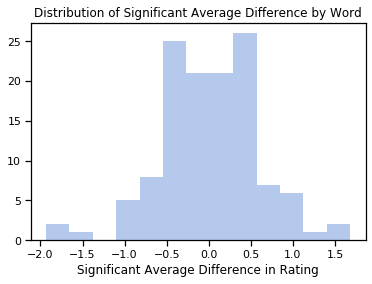

,diff_avg
count,125.000000
mean,0.000564
std,0.584384
min,-1.934883
25%,-0.335259
50%,0.042483
75%,0.378952
max,1.681499


In [98]:
# create dataframe of sig. average difference by word
diff_avg_terms = pd.DataFrame(diff_avg_terms, columns=['word', 'diff_avg'])

# plot distribution
sns.distplot(diff_avg_terms['diff_avg'], kde=False)
plt.xlabel('Significant Average Difference in Rating')
plt.title('Distribution of Significant Average Difference by Word')
plt.show()

# display summary statistics
display(diff_avg_terms.describe())

In [99]:
# display 10 words with largest significant average increase
top_diff_avg_terms = diff_avg_terms.sort_values('diff_avg', ascending=False)[:10]
display('10 words with largest average increase in rating:', top_diff_avg_terms)

# display 10 words with largest significant average decrease
bottom_diff_avg_terms = diff_avg_terms.sort_values('diff_avg', ascending=True)[:10]
display('10 words with largest average decrease in rating:', bottom_diff_avg_terms)

'10 words with largest average increase in rating:'

,word,diff_avg
124,best,1.681499
123,love,1.576991
122,great,1.151156
121,life,1.070807
120,year,0.953543
119,gone,0.946549
118,far,0.870904
117,without,0.853559
116,abl,0.851315
115,work,0.824908


'10 words with largest average decrease in rating:'

,word,diff_avg
0,wors,-1.934883
1,horribl,-1.751929
2,bleed,-1.522441
3,stop,-1.074971
4,switch,-1.058646
5,extrem,-1.042193
6,caus,-0.989315
7,never,-0.900904
8,made,-0.770485
9,headach,-0.725796
